<a href="https://colab.research.google.com/github/iremakalp/ETicaret/blob/master/plant_test_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **1. Kütüphaneleri ekleme**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q split-folders

In [ ]:
#library to create UI components to depoly and test the model
!pip install -q gradio

     |████████████████████████████████| 2.0 MB 20.6 MB/s 
     |████████████████████████████████| 1.9 MB 38.2 MB/s 
     |████████████████████████████████| 206 kB 46.3 MB/s 
     |████████████████████████████████| 3.5 MB 36.4 MB/s 
     |████████████████████████████████| 961 kB 35.8 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


In [ ]:
import os
import splitfolders #Dosyaları (örn. resimleri) içeren klasörleri train(egitim) , dogrulama(value) ve test (veri kümesi) klasorlerine ayirir.
import time

#grafik olusturmak icin
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

#CNN modeli oluşturmak için gerekli kütüphaneler
import tensorflow as tf
import keras
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

#arayuz bileşenlerini oluşturmak için
import gradio as gr 
import requests


#### ***2. Train, Test ve Validation klasörlerini oluşturma***

In [ ]:
# Veri Kümesini train test val klasörlerine ayırın
# ratio => belirli bir oranti ile boler
splitfolders.ratio("/content/drive/MyDrive/Proje-A/dataset/plant_images", output="output", 
                   seed=100, ratio=(.7, .2, .1), group_prefix=None) 

Copying files: 720 files [02:44,  4.39 files/s]


 #### **3. Train-Test verilerinin Sayısını Öğrenme**

In [ ]:
#Training data

#create paths for each folders
applediseased_dir = os.path.join('./output/train/apple-diseased')
applehealthy_dir = os.path.join('./output/train/apple-healthy')
grapediseased_dir = os.path.join('./output/train/grape-healthy')
grapehealthy_dir = os.path.join('./output/train/grape-diseased')
tomatodiseased_dir = os.path.join('./output/train/tomato-diseased')
tomatohealthy_dir = os.path.join('./output/train/tomato-healthy')

#create list of image path
applediseased_files = os.listdir(applediseased_dir)
applehealthy_files = os.listdir(applehealthy_dir)
grapehealthy_files = os.listdir(grapehealthy_dir)
grapediseased_files = os.listdir(grapediseased_dir)
tomatodiseased_files = os.listdir(tomatodiseased_dir)
tomatohealthyfiles = os.listdir(tomatohealthy_dir)

print("Total len of training images",len(applediseased_files+applehealthy_files+grapehealthy_files+grapediseased_files+tomatodiseased_files+tomatohealthyfiles),'\n')


Total len of training images 504 



In [ ]:
#Test data

#create paths for each folders
applediseased_dir_test = os.path.join('./output/test/apple-diseased')
applehealthy_dir_test = os.path.join('./output/test/apple-healthy')
grapehealthy_dir_test = os.path.join('./output/test/grape-healthy')
grapediseased_dir_test = os.path.join('./output/test/grape-diseased')
tomatodiseased_dir_test = os.path.join('./output/test/tomato-diseased')
tomatohealthy_dir_test = os.path.join('./output/test/tomato-healthy')

#create list of image path
appled_files_test = os.listdir(applediseased_dir_test)
appleh_files_test = os.listdir(applehealthy_dir_test)
graped_files_test = os.listdir(grapediseased_dir_test)
grapeh_files_test = os.listdir(grapehealthy_dir_test)
tomatod_files_test = os.listdir(tomatodiseased_dir_test)
tomatoh_files_test = os.listdir(tomatohealthy_dir_test)

print("Total len of test images",len(appled_files_test+appleh_files_test+graped_files_test+grapeh_files_test+tomatod_files_test+tomatoh_files_test),'\n')

Total len of test images 72 



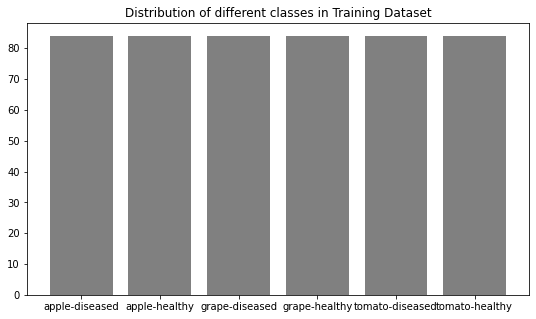

In [ ]:
#plot count of images for each class

# creating a dictionary of the images in train dataset: values = number of images; key = Folder name
image_folder = ['apple-diseased', 'apple-healthy','grape-diseased','grape-healthy','tomato-diseased','tomato-healthy']
dict_imgs = {}              
for i in image_folder:
    nimages = len(os.listdir('./output/train/'+i))
    dict_imgs[i]=nimages


# plotting a bargraph
plt.figure(figsize=(9, 5))
plt.bar(range(len(dict_imgs)), list(dict_imgs.values()), align='center',color='grey')
plt.xticks(range(len(dict_imgs)), list(dict_imgs.keys()))
plt.title('Distribution of different classes in Training Dataset')
plt.show()

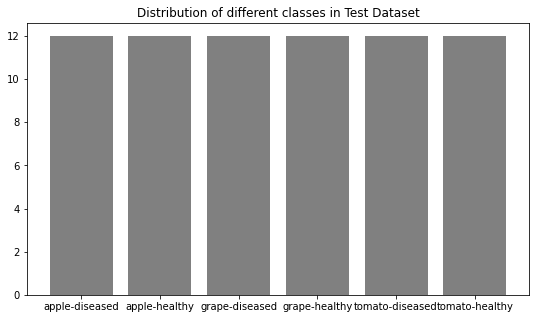

In [ ]:
#plot count of images for each class

# creating a dictionary of the images in train dataset: values = number of images; key = Folder name
image_folder = ['apple-diseased', 'apple-healthy','grape-diseased','grape-healthy','tomato-diseased','tomato-healthy']
dict_imgs = {}              
for i in image_folder:
    nimages = len(os.listdir('./output/test/'+i))
    dict_imgs[i]=nimages


# plotting a bargraph
plt.figure(figsize=(9, 5))
plt.bar(range(len(dict_imgs)), list(dict_imgs.values()), align='center',color='grey')
plt.xticks(range(len(dict_imgs)), list(dict_imgs.keys()))
plt.title('Distribution of different classes in Test Dataset')
plt.show()

#### **4. Ön İşleme - Veri Geliştirme**

Veri büyütme, eğitim setinin boyutunu artırmak ve daha farklı bir görüntü elde etmek için kullanılır. Veri büyütme sayesinde fazla sığdırmayı önleyebiliriz. Bu, görüntülerin yatay çevirme, yakınlaştırma ve döndürme gibi yorumlarını etkilememesi gereken şekillerde rastgele değiştirilmesi anlamına gelir.


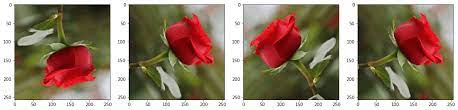

##### ***4.1 ImageDataGenerator*** 

In [ ]:
#Train verilerinde ImageDataGenerator kullanarak görüntü büyütme 
#Veri büyütme, eğitim setinin boyutunu artırmak ve daha farklı görüntüler elde etmek için kullanılır
training_dir = './output/train/'
training_datagen = ImageDataGenerator(
    rescale = 1./255, #normalization
    rotation_range = 40, #resmi dondurur
    width_shift_range = 0.4, #sola veya sağa kaydırma (yatay kaymalar)
    height_shift_range = 0.4, #görüntüleri yukarı veya aşağı kaydır (dikey olarak)
    shear_range = 0.2, #derece cinsinden saat yönünün tersine kayma açısı
    zoom_range = 0.1, #yakinlastirma
    fill_mode = 'nearest', # Giriş alanında yeni kaydırılan piksel için kurallar belirler.
    horizontal_flip = True) #görüntüyü yatay olarak çevir

In [ ]:
#dogrulama ve test setinde buyutme yapılmadi cunku sonucu yanlis yonlendirebilir
validation_dir = './output/val'
validation_datagen = ImageDataGenerator(
    rescale=1./255 #normalization
)

test_dir = './output/test'
test_datagen = ImageDataGenerator(
    rescale=1./255 #normalization
)

In [ ]:
#flow_from_directory() yöntemi, sinir ağı modeli eğitim verilerini öğrenirken görüntüleri 
#doğrudan dizinden okumanıza ve büyütmenize olanak tanır.
train_generator = training_datagen.flow_from_directory(
    training_dir, #Verilerin bulunduğu dizin
    #görüntülerin boyutu değişiyorsa görüntüleri sabit boyutta yeniden boyutlandırın
    target_size = (256,256), 
    class_mode = 'categorical', #çok sınıflı
    batch_size = 32 #Veri gruplarının boyutu
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (256,256),
    class_mode = 'categorical',
    batch_size = 32
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (256,256),
    class_mode = 'categorical',
    batch_size = 32
)

Found 504 images belonging to 6 classes.
Found 144 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


#### **5. CNN Model Building**

Evrişimsel Sinir Ağı (ConvNet/CNN), bir girdi görüntüsünü alabilen, görüntüdeki çeşitli yönlere/nesnelere önem (öğrenilebilir ağırlıklar ve önyargılar) atayan ve birini diğerinden ayırt edebilen bir Derin Öğrenme algoritmasıdır. Bir ConvNet'te gereken ön işleme, diğer sınıflandırma algoritmalarına kıyasla çok daha düşüktür. İlkel yöntemlerde filtreler elle tasarlanırken, yeterli eğitimle ConvNet'ler bu filtreleri/özellikleri öğrenme yeteneğine sahiptir.

In [ ]:
# CNN sıralı modelini oluşturun ve sıfırdan eğitin
def model_from_scratch():
  model = tf.keras.models.Sequential([
              tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (256,256,3)), 
              tf.keras.layers.MaxPool2D(2,2),
              tf.keras.layers.Dropout(0.5),

              tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
              tf.keras.layers.MaxPool2D(2,2),
              tf.keras.layers.Dropout(0.5),

              tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'), 
              tf.keras.layers.MaxPool2D(2,2),
              tf.keras.layers.Dropout(0.5),
              
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Dense(512, activation = 'relu'), #Dense layer(fully connected layer)
              tf.keras.layers.Dense(6, activation = 'softmax') #output layer
  ])

  
  return model


##### ***5.1 Model Özeti*** 

In [ ]:
#Model Özeti: Ağın tüm katmanlarını görüntüleyin
model = model_from_scratch()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       7

##### ***5.2 Model Compilation***

In [ ]:
#model compilation
model.compile(loss='categorical_crossentropy', #cok sinifli
              optimizer = tf.keras.optimizers.Adam(), #en iyi optimize edici
              metrics = ['accuracy'] #kullanılan performans metrikleri
            )

#### ***6. Modelin Eğitimi***

In [ ]:
#veri kümesini eğitmek için uygun model
epochs = 10
start = time.time()

#fitting a model=> model egitmek
history1 = model.fit(train_generator, #Input train data
                    epochs=epochs, #number of epochs
                    validation_data=validation_generator,#validation data
                    validation_steps=5, 
                    verbose=1
                     )

end = time.time()
duration = end - start
print ('\n Model built from scratch training took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Epoch 1/10
16/16 [==============================] - 89s 5s/step - loss: 7.4684 - accuracy: 0.1290 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 2/10
16/16 [==============================] - 85s 5s/step - loss: 1.7917 - accuracy: 0.1667 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 3/10
16/16 [==============================] - 86s 5s/step - loss: 1.7919 - accuracy: 0.1667 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 4/10
16/16 [==============================] - 75s 5s/step - loss: 1.7919 - accuracy: 0.1667 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 5/10
16/16 [==============================] - 77s 5s/step - loss: 1.7918 - accuracy: 0.1667 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 6/10
16/16 [==============================] - 75s 5s/step - loss: 1.7919 - accuracy: 0.1667 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 7/10
16/16 [==============================] - 75s 5s/step - loss: 1.7919 - accuracy: 0.1667 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 8/10
16/16 [==

### ***7. Grafikler***

In [ ]:
def get_history_data(history):
    
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  return train_acc,val_acc,train_loss,val_loss

In [ ]:
train_acc,val_acc,train_loss,val_loss = get_history_data(history1)

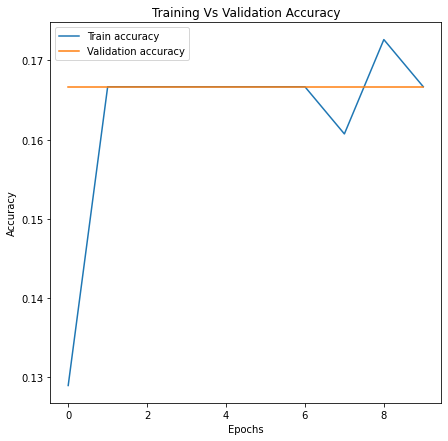

In [ ]:
epochs = range(len(train_acc))
plt.figure(figsize=(7,7));
plt.plot(epochs,train_acc,label ='Train accuracy');
plt.plot(epochs,val_acc,label ='Validation accuracy');
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();
plt.title('Training Vs Validation Accuracy');

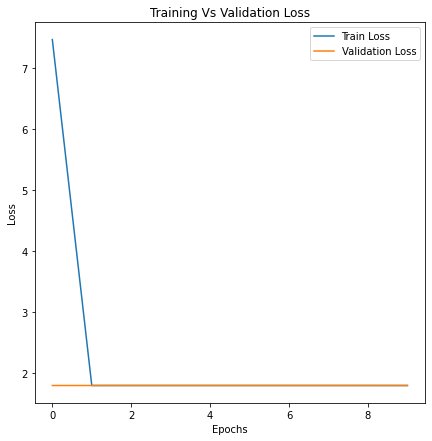

In [ ]:
plt.figure(figsize=(7,7));
plt.plot(epochs,train_loss,label ='Train Loss');
plt.plot(epochs,val_loss,label ='Validation Loss');
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();
plt.title('Training Vs Validation Loss');

### **8. Testing Model**

In [ ]:
#modelin test verilerinde nasıl performans gösterdiğini kontrol edin
model.evaluate(test_generator)

3/3 [==============================] - 3s 601ms/step - loss: 1.7918 - accuracy: 0.1667


[1.791765809059143, 0.1666666716337204]

#### ***8.4 Save the model***

In [ ]:
model.save('./model.h5')

#### ***8.5 Test model***

In [ ]:
try:
  labels = ['apple-diseased', 'apple-healthy','grape-diseased','grape-healthy','tomato-diseased','tomato-healthy'] #classes

  def classify_image(inp):
    img = inp.reshape((-1,256,256,3)) #giriş görüntüsünü yeniden şekillendir
    prediction = model.predict(img).flatten() #prediction
    return {labels[i]: float(prediction[i]) for i in range(5)} 

  image = gr.inputs.Image(shape=(256, 256))
  label = gr.outputs.Label(num_top_classes=6)

  gr.Interface(fn=classify_image, inputs=image, outputs=label, capture_session=True).launch(debug=True,share=True)

except KeyboardInterrupt:
      pass

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://47765.gradio.app
